In [1]:
import pandas as pd

In [30]:
df_raw = pd.read_csv('data.csv')
df_raw.drop(columns=['Unnamed: 0'], inplace=True)
df = df_raw.copy()
df.head()

,Time,Resource,State,Activity,Expected End Time,Material,Target location
0,14.532972,R3,Breakdownstate_2,start state,44.532972,NaN,NaN
1,19.776715,R1,P1,start state,30.576129,Material_1 instance N.0,NaN
2,30.576129,R1,P1,end state,30.576129,Material_1 instance N.0,NaN
3,30.576129,TR1,TP1,start state,31.059462,Material_1 instance N.0,R1
4,31.059462,TR1,TP1,end state,31.059462,Material_1 instance N.0,R1


In [31]:
import pm4py
import os
os.environ["PATH"] += os.pathsep + "C:/Program Files/Graphviz/bin"

In [32]:
df['DateTime'] = pd.to_datetime(df['Time'], unit='m')
df['Material_type'] = df['Material'].str[:10]
df['Combined_activity'] = df['State'] + ' ' + df['Activity']

In [34]:
df_for_pm4py = df.loc[df['Material'].notnull()]
df_for_pm4py = df_for_pm4py.rename(columns={'Material_type': 'Material:Material_type'})
df_for_pm4py = df_for_pm4py.loc[df_for_pm4py['Material:Material_type'] == 'Material_1']
df_for_pm4py = pm4py.format_dataframe(df_for_pm4py, case_id='Material', activity_key='Combined_activity', timestamp_key='DateTime')
log = pm4py.convert_to_event_log(df_for_pm4py)

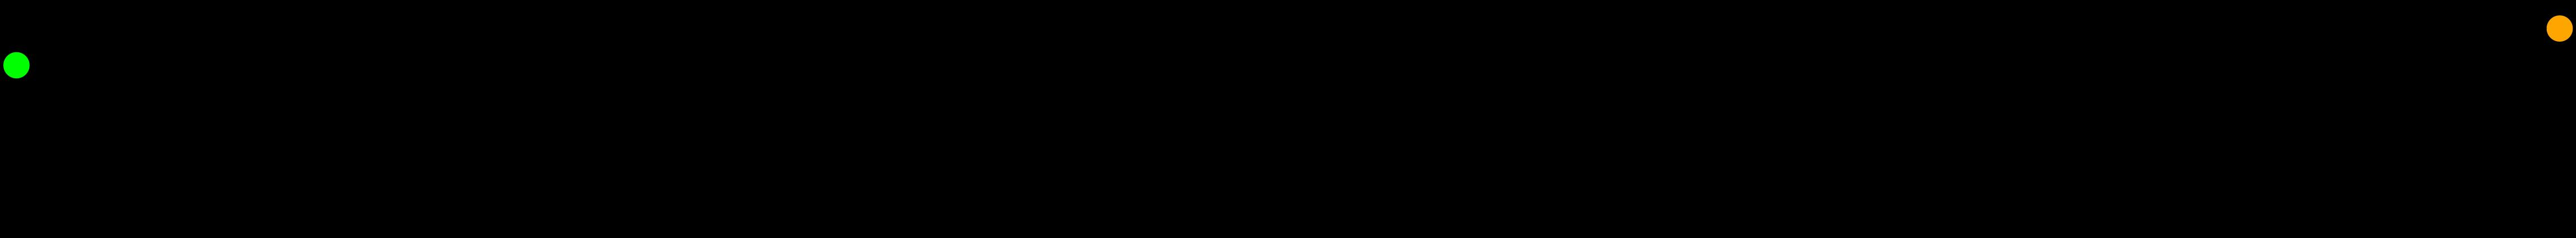

In [36]:
process_tree = pm4py.discover_process_tree_inductive(log)
bpmn_model = pm4py.convert_to_bpmn(process_tree)
pm4py.view_bpmn(bpmn_model, format = "jpeg")

In [37]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log)
# pm4py.view_petri_net(net, initial_marking, final_marking)


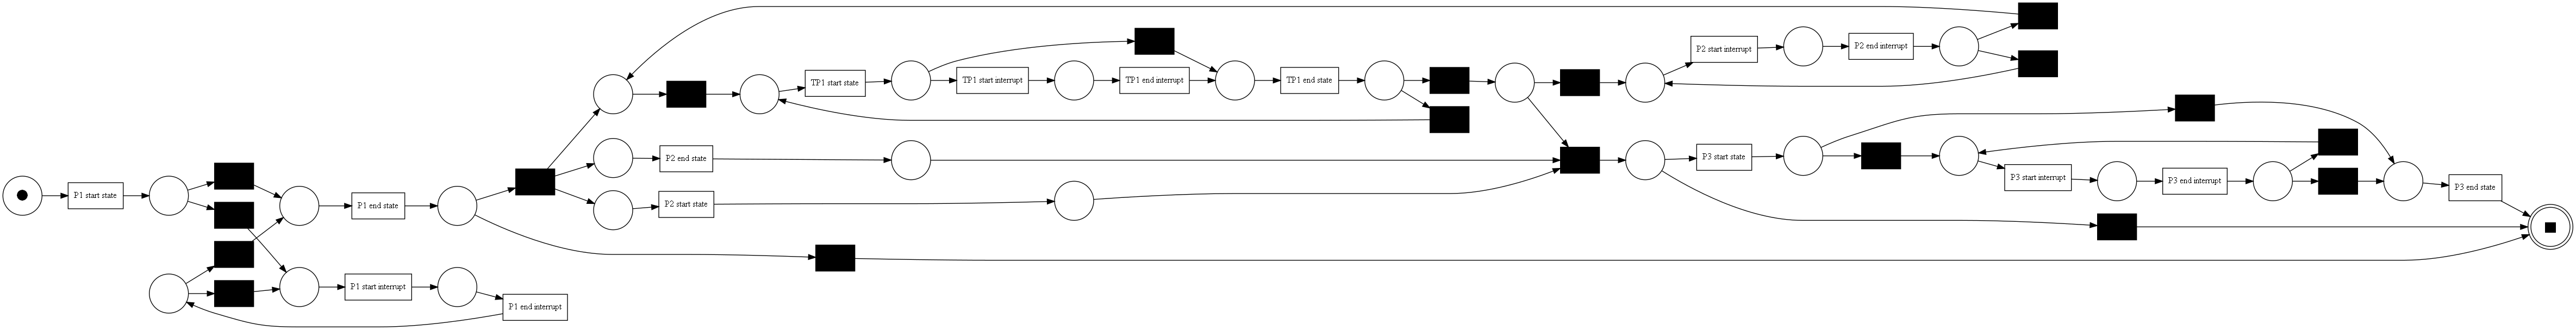

In [38]:
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log)
pm4py.view_petri_net(net, initial_marking, final_marking)

In [39]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters, variant=pn_visualizer.Variants.FREQUENCY, log=log)
pn_visualizer.save(gviz, "inductive_frequency.png")
# gviz.view()

replaying log with TBR, completed variants :: 100%|██████████| 72/72 [00:00<00:00, 367.63it/s]


In [40]:
# pm4py.discover_directly_follows_graph(log)

In [41]:
df = df_raw.copy()
df['Material_type'] = df['Material'].str[:10]
df.loc[df['State'].str.contains('P'), 'State_type'] = 'Process State'
df.loc[df['State'].str.contains('Breakdown'), 'State_type'] = 'Breakdown State'

In [42]:
df_process_lengths = pd.DataFrame({'Material_type': ['Material_1', 'Material_2'], 'length': [3, 4]})
df_process_lengths

,Material_type,length
0,Material_1,3
1,Material_2,4


In [43]:
starts = df.loc[(df['Activity'] == "end state") & (df['State'].isin(['P1', 'P2', 'P3', 'P4']))].groupby(by='Material')['Activity'].count()
starts.name = "process_starts"
ends = df.loc[(df['Activity'] == "end state") & (df['State'].isin(['P1', 'P2', 'P3', 'P4']))].groupby(by='Material')['Activity'].count()
ends.name = "process_ends"
df_finished_material = pd.merge(df[['Material_type', 'Material']].drop_duplicates(), starts.to_frame().reset_index())
df_finished_material = pd.merge(df_finished_material, ends.to_frame().reset_index())
df_finished_material = pd.merge(df_finished_material, df_process_lengths)
df_finished_material['has_finished'] = (df_finished_material['process_starts'] == df_finished_material['length']) &  (df_finished_material['process_ends'] == df_finished_material['length'])
df_finished_material = df_finished_material.loc[df_finished_material['has_finished']]
df_finished_material

,Material_type,Material,process_starts,process_ends,length,has_finished
0,Material_1,Material_1 instance N.0,3,3,3,True
1,Material_1,Material_1 instance N.1,3,3,3,True
2,Material_1,Material_1 instance N.5,3,3,3,True
3,Material_1,Material_1 instance N.4,3,3,3,True
4,Material_1,Material_1 instance N.6,3,3,3,True
...,...,...,...,...,...,...
2197,Material_2,Material_2 instance N.2138,4,4,4,True
2198,Material_2,Material_2 instance N.2141,4,4,4,True
2202,Material_2,Material_2 instance N.2155,4,4,4,True
2207,Material_2,Material_2 instance N.2182,4,4,4,True


In [55]:
df_only_finished = df.loc[df['Material'].isin(df_finished_material['Material'])].copy()
df_only_finished['DateTime'] = pd.to_datetime(df_only_finished['Time'], unit='m')
df_only_finished['Material_type'] = df_only_finished['Material'].str[:10]
df_only_finished['Combined_activity'] = df_only_finished['State'] + ' ' + df_only_finished['Activity']

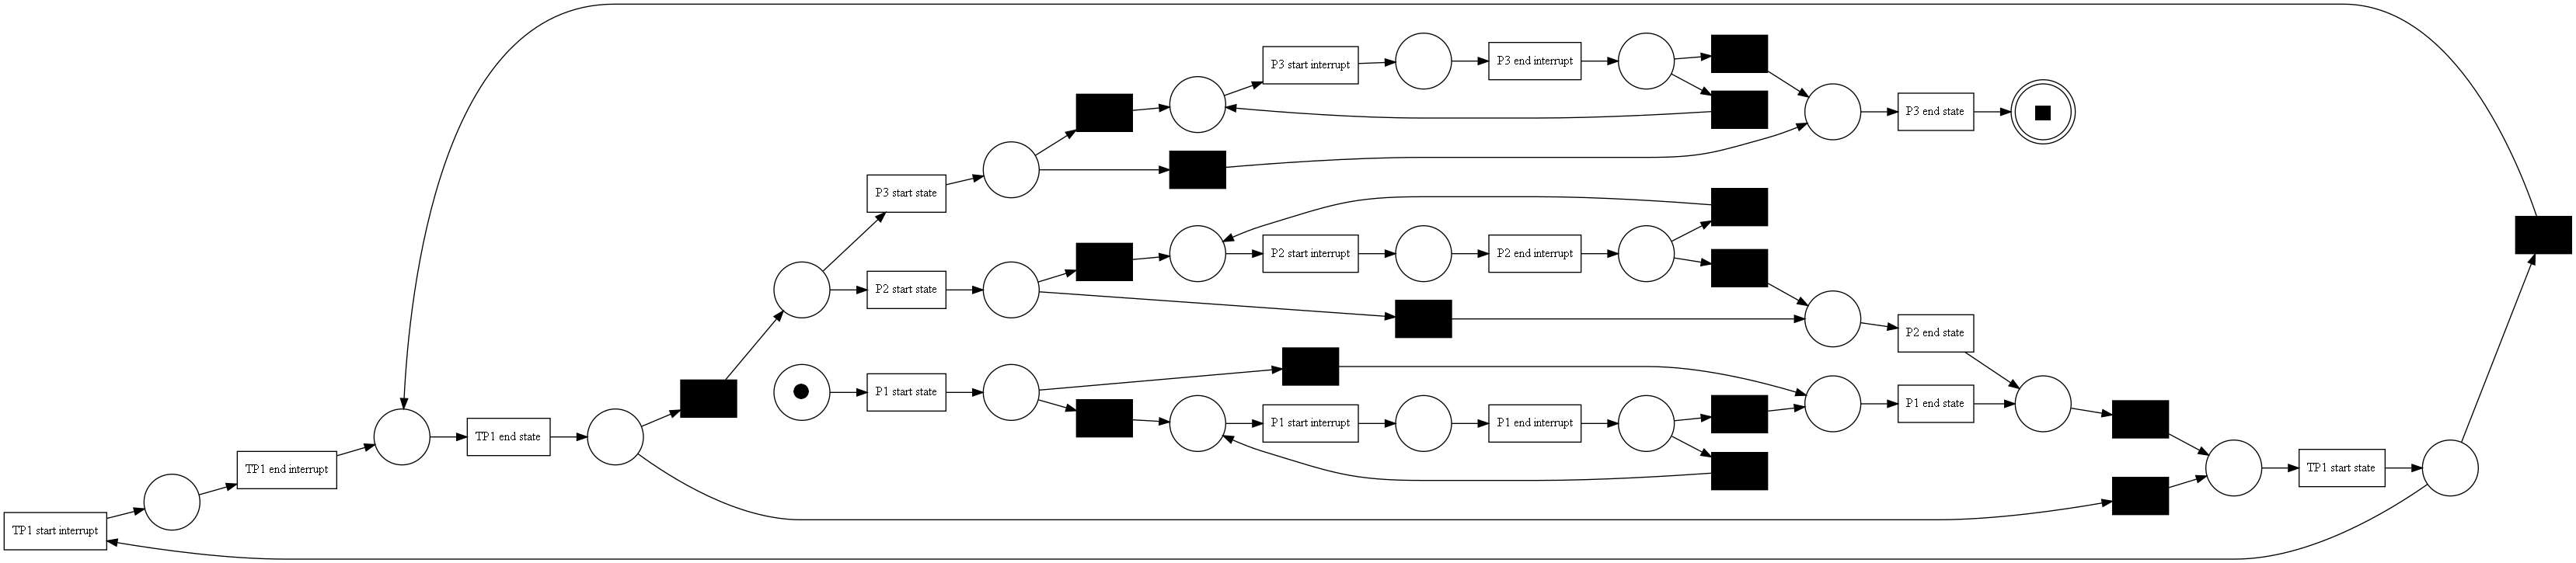

In [56]:
df_for_pm4py = df_only_finished.loc[df_only_finished['Material'].notnull()]
df_for_pm4py = df_for_pm4py.rename(columns={'Material_type': 'Material:Material_type'})
df_for_pm4py = df_for_pm4py.loc[df_for_pm4py['Material:Material_type'] == 'Material_1']
df_for_pm4py = pm4py.format_dataframe(df_for_pm4py, case_id='Material', activity_key='Combined_activity', timestamp_key='DateTime')
log = pm4py.convert_to_event_log(df_for_pm4py)
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log)
pm4py.view_petri_net(net, initial_marking, final_marking)

In [ ]:
    from pm4py.convert import convert_to_petri_net
    from pm4py.objects.conversion.process_tree.variants import to_petri_net

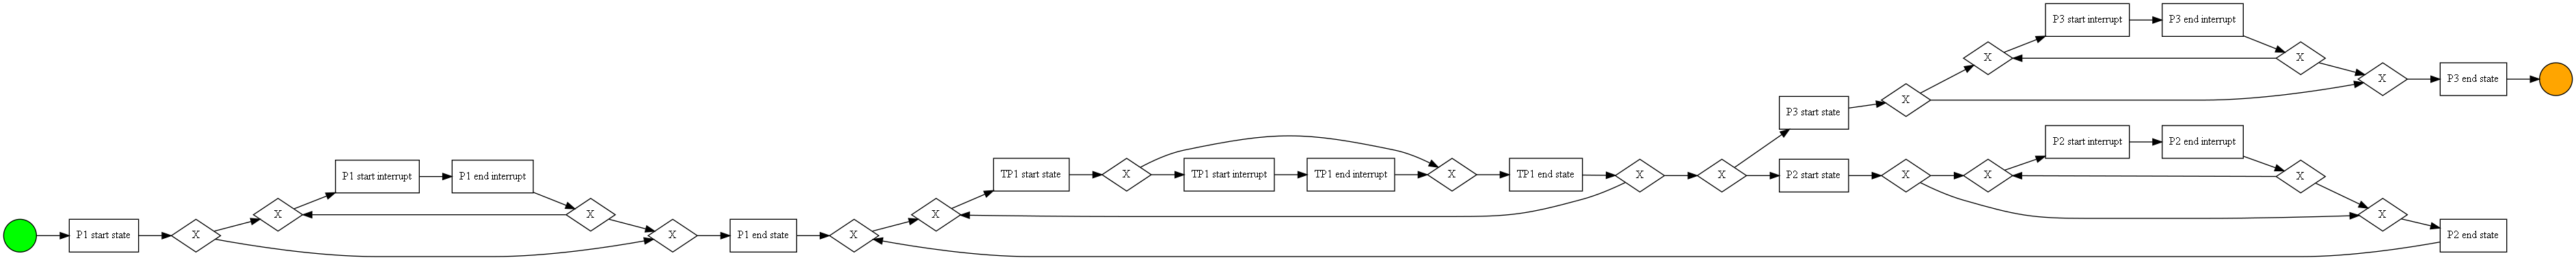

In [57]:
process_tree = pm4py.discover_process_tree_inductive(log)
bpmn_model = pm4py.convert_to_bpmn(process_tree)
pm4py.view_bpmn(bpmn_model, format = "png")

In [843]:
min = df.groupby(by='Material')['Time'].min()
min.name = "Start_time"
max = df.groupby(by='Material')['Time'].max()
max.name = "End_time"
tp = max - min
tp.name = "Throughput_time"

In [844]:
df_tp = pd.merge(df[['Material_type', 'Material']].drop_duplicates(), tp.to_frame().reset_index())
df_tp = pd.merge(df_tp, min.to_frame().reset_index())

In [845]:
import plotly.figure_factory as ff
import numpy as np

# Group data together
# hist_data = [x1, x2, x3, x4]

grouped = df_tp.groupby(by='Material_type')['Throughput_time'].apply(list)

values = grouped.values

group_labels = grouped.index

# Create distplot with custom bin_size
fig = ff.create_distplot(values, group_labels, bin_size=.2)
fig.show()

In [846]:
import plotly.express as px

fig = px.scatter(df_tp, x="Start_time", y="Throughput_time", color="Material_type")

fig.show()

In [847]:
df_unique = df[['State_type', 'Activity']].drop_duplicates().sort_values(by=['State_type', 'Activity'])
# df_unique['State_sorting_Index'] = [4, 3, 5, 6, 2, 1]
# df_unique['State_sorting_Index'] = [5, 4, 6, 1, 3, 2]
df_unique['State_sorting_Index'] = [1, 6, 2, 3, 5, 4]

df_unique.sort_values(by='State_sorting_Index', inplace=True)
df_unique

,State_type,Activity,State_sorting_Index
8,Breakdown State,end state,1
20,Process State,end interrupt,2
2,Process State,end state,3
1,Process State,start state,4
14,Process State,start interrupt,5
0,Breakdown State,start state,6


In [848]:
df = pd.merge(df, df_unique)
df = df.sort_values(by=['Time', 'Resource', 'State_sorting_Index'])
df.head()

,Time,Resource,State,Activity,Expected End Time,Material,Target location,Material_type,State_type,State_sorting_Index
0,14.532972,R3,Breakdownstate_2,start state,44.532972,NaN,NaN,NaN,Breakdown State,6
1468,19.776715,R1,P1,start state,30.576129,Material_1 instance N.0,NaN,Material_1,Process State,4
18615,30.576129,R1,P1,end state,30.576129,Material_1 instance N.0,NaN,Material_1,Process State,3
1469,30.576129,TR1,TP1,start state,31.059462,Material_1 instance N.0,R1,Material_1,Process State,4
18616,31.059462,TR1,TP1,end state,31.059462,Material_1 instance N.0,R1,Material_1,Process State,3


In [849]:
positive_condition = (df['State_type'] == 'Process State') & (df['Activity'] == 'start state')
negative_condition = (df['State_type'] == 'Process State') & (df['Activity'] == 'end state')

df['Increment'] = 0
df.loc[positive_condition, 'Increment'] = 1
df.loc[negative_condition, 'Increment'] = -1

df['Used_Capacity'] = df.groupby(by='Resource')['Increment'].cumsum()
df.head(20)

,Time,Resource,State,Activity,Expected End Time,Material,Target location,Material_type,State_type,State_sorting_Index,Increment,Used_Capacity
0,14.532972,R3,Breakdownstate_2,start state,44.532972,NaN,NaN,NaN,Breakdown State,6,0,0
1468,19.776715,R1,P1,start state,30.576129,Material_1 instance N.0,NaN,Material_1,Process State,4,1,1
18615,30.576129,R1,P1,end state,30.576129,Material_1 instance N.0,NaN,Material_1,Process State,3,-1,0
1469,30.576129,TR1,TP1,start state,31.059462,Material_1 instance N.0,R1,Material_1,Process State,4,1,1
18616,31.059462,TR1,TP1,end state,31.059462,Material_1 instance N.0,R1,Material_1,Process State,3,-1,0
1470,31.059462,TR1,TP1,start state,31.542795,Material_1 instance N.0,R2,Material_1,Process State,4,1,1
1471,31.542795,R2,P2,start state,46.542795,Material_1 instance N.0,NaN,Material_1,Process State,4,1,1
18617,31.542795,TR1,TP1,end state,31.542795,Material_1 instance N.0,R2,Material_1,Process State,3,-1,0
35761,44.532972,R3,Breakdownstate_2,end state,44.532972,NaN,NaN,NaN,Breakdown State,1,0,0
18618,46.542795,R2,P2,end state,46.542795,Material_1 instance N.0,NaN,Material_1,Process State,3,-1,0


In [850]:
df.groupby('Resource')['Used_Capacity'].max()

Resource
R1     2
R2     1
R3     2
R4     2
TR1    1
TR2    1
Name: Used_Capacity, dtype: int64

In [851]:
import plotly.express as px

fig = px.scatter(df, x="Time", y="Used_Capacity", color="Resource")

# fig.show()

In [852]:
df.head()

,Time,Resource,State,Activity,Expected End Time,Material,Target location,Material_type,State_type,State_sorting_Index,Increment,Used_Capacity
0,14.532972,R3,Breakdownstate_2,start state,44.532972,NaN,NaN,NaN,Breakdown State,6,0,0
1468,19.776715,R1,P1,start state,30.576129,Material_1 instance N.0,NaN,Material_1,Process State,4,1,1
18615,30.576129,R1,P1,end state,30.576129,Material_1 instance N.0,NaN,Material_1,Process State,3,-1,0
1469,30.576129,TR1,TP1,start state,31.059462,Material_1 instance N.0,R1,Material_1,Process State,4,1,1
18616,31.059462,TR1,TP1,end state,31.059462,Material_1 instance N.0,R1,Material_1,Process State,3,-1,0


In [853]:
df['next_State_sorting_Index'] = df.groupby(by='Resource')['State_sorting_Index'].shift(-1)
df['next_Time'] = df.groupby('Resource')['Time'].shift(-1)
df.head()

,Time,Resource,State,Activity,Expected End Time,Material,Target location,Material_type,State_type,State_sorting_Index,Increment,Used_Capacity,next_State_sorting_Index,next_Time
0,14.532972,R3,Breakdownstate_2,start state,44.532972,NaN,NaN,NaN,Breakdown State,6,0,0,1.0,44.532972
1468,19.776715,R1,P1,start state,30.576129,Material_1 instance N.0,NaN,Material_1,Process State,4,1,1,3.0,30.576129
18615,30.576129,R1,P1,end state,30.576129,Material_1 instance N.0,NaN,Material_1,Process State,3,-1,0,4.0,51.113404
1469,30.576129,TR1,TP1,start state,31.059462,Material_1 instance N.0,R1,Material_1,Process State,4,1,1,3.0,31.059462
18616,31.059462,TR1,TP1,end state,31.059462,Material_1 instance N.0,R1,Material_1,Process State,3,-1,0,4.0,31.059462


In [854]:
df[['State_sorting_Index', 'next_State_sorting_Index']].value_counts()

State_sorting_Index  next_State_sorting_Index
3                    4.0                         15518
4                    3.0                         15491
6                    1.0                          1466
3                    3.0                           988
4                    4.0                           982
5                    6.0                           856
1                    2.0                           855
4                    5.0                           674
2                    3.0                           667
1                    4.0                           567
3                    6.0                           567
2                    2.0                           301
5                    5.0                           301
2                    5.0                           112
                     4.0                            76
3                    5.0                            70
1                    6.0                            43
dtype: int64

In [855]:
df_unique

,State_type,Activity,State_sorting_Index
8,Breakdown State,end state,1
20,Process State,end interrupt,2
2,Process State,end state,3
1,Process State,start state,4
14,Process State,start interrupt,5
0,Breakdown State,start state,6


In [856]:
STANDBY_CONDITION = (df['State_sorting_Index'] == 1) | ((df['State_sorting_Index'] == 3) & (df['Used_Capacity'] == 0))
PRODUCTIVE_CONDITION = (df['State_sorting_Index'] == 4) | (df['State_sorting_Index'] == 2) | ((df['State_sorting_Index'] == 3) & df['Used_Capacity'] != 0)
DOWN_CONDITION = (df['State_sorting_Index'] == 5) | (df['State_sorting_Index'] == 6)

df['time_increment'] = df['next_Time'] - df['Time']

df.loc[STANDBY_CONDITION, 'Time_type'] = 'SB'
df.loc[PRODUCTIVE_CONDITION, 'Time_type'] = 'PR'
df.loc[DOWN_CONDITION, 'Time_type'] = 'UD'

In [857]:
df.head()

,Time,Resource,State,Activity,Expected End Time,Material,Target location,Material_type,State_type,State_sorting_Index,Increment,Used_Capacity,next_State_sorting_Index,next_Time,time_increment,Time_type
0,14.532972,R3,Breakdownstate_2,start state,44.532972,NaN,NaN,NaN,Breakdown State,6,0,0,1.0,44.532972,30.000000,UD
1468,19.776715,R1,P1,start state,30.576129,Material_1 instance N.0,NaN,Material_1,Process State,4,1,1,3.0,30.576129,10.799414,PR
18615,30.576129,R1,P1,end state,30.576129,Material_1 instance N.0,NaN,Material_1,Process State,3,-1,0,4.0,51.113404,20.537276,SB
1469,30.576129,TR1,TP1,start state,31.059462,Material_1 instance N.0,R1,Material_1,Process State,4,1,1,3.0,31.059462,0.483333,PR
18616,31.059462,TR1,TP1,end state,31.059462,Material_1 instance N.0,R1,Material_1,Process State,3,-1,0,4.0,31.059462,0.000000,SB


In [858]:
# df.loc[df['Resource'] == 'R3', ['Time', 'State', 'Activity', 'State_sorting_Index', 'Used_Capacity', 'time_increment', 'Time_type']].head()

In [859]:
df_time_per_state = df.groupby(['Resource', 'Time_type'])['time_increment'].sum()
df_time_per_state = df_time_per_state.to_frame().reset_index()
df_time_per_state

,Resource,Time_type,time_increment
0,R1,PR,26777.687618
1,R1,SB,7438.185974
2,R1,UD,5760.000000
3,R2,PR,30802.310324
4,R2,SB,3404.055297
5,R2,UD,5730.000000
6,R3,PR,26103.072208
7,R3,SB,772.495038
8,R3,UD,13080.000000
9,R4,PR,12359.227254


In [860]:
df_resource_time

,Resource,resource_time
0,R1,39975.873592
1,R2,39936.365622
2,R3,39955.567246
3,R4,39874.924210
4,TR1,39829.059356
5,TR2,39806.344534


In [861]:
df_resource_time = df_time_per_state.groupby(by='Resource').sum().reset_index()
df_resource_time.rename(columns={'time_increment': 'resource_time'}, inplace=True)
df_time_per_state = pd.merge(df_time_per_state, df_resource_time)
# time_ratio = df_time_ratio / df_time_ratio_resource_time
df_time_per_state['percentage'] = df_time_per_state['time_increment'] / df_time_per_state['resource_time']

In [862]:
df_time_per_state

,Resource,Time_type,time_increment,resource_time,percentage
0,R1,PR,26777.687618,39975.873592,0.669846
1,R1,SB,7438.185974,39975.873592,0.186067
2,R1,UD,5760.000000,39975.873592,0.144087
3,R2,PR,30802.310324,39936.365622,0.771285
4,R2,SB,3404.055297,39936.365622,0.085237
5,R2,UD,5730.000000,39936.365622,0.143478
6,R3,PR,26103.072208,39955.567246,0.653303
7,R3,SB,772.495038,39955.567246,0.019334
8,R3,UD,13080.000000,39955.567246,0.327364
9,R4,PR,12359.227254,39874.924210,0.309950


In [863]:
import plotly.express as px

fig = px.bar(df_time_per_state, x="Resource", y="time_increment", color="Time_type", color_discrete_map={'PR': 'green', 'SB': 'yellow', 'UD': 'red' })
fig.show()

In [864]:
df.head(30)

,Time,Resource,State,Activity,Expected End Time,Material,Target location,Material_type,State_type,State_sorting_Index,Increment,Used_Capacity,next_State_sorting_Index,next_Time,time_increment,Time_type
0,14.532972,R3,Breakdownstate_2,start state,44.532972,NaN,NaN,NaN,Breakdown State,6,0,0,1.0,44.532972,30.000000,UD
1468,19.776715,R1,P1,start state,30.576129,Material_1 instance N.0,NaN,Material_1,Process State,4,1,1,3.0,30.576129,10.799414,PR
18615,30.576129,R1,P1,end state,30.576129,Material_1 instance N.0,NaN,Material_1,Process State,3,-1,0,4.0,51.113404,20.537276,SB
1469,30.576129,TR1,TP1,start state,31.059462,Material_1 instance N.0,R1,Material_1,Process State,4,1,1,3.0,31.059462,0.483333,PR
18616,31.059462,TR1,TP1,end state,31.059462,Material_1 instance N.0,R1,Material_1,Process State,3,-1,0,4.0,31.059462,0.000000,SB
1470,31.059462,TR1,TP1,start state,31.542795,Material_1 instance N.0,R2,Material_1,Process State,4,1,1,3.0,31.542795,0.483333,PR
1471,31.542795,R2,P2,start state,46.542795,Material_1 instance N.0,NaN,Material_1,Process State,4,1,1,3.0,46.542795,15.000000,PR
18617,31.542795,TR1,TP1,end state,31.542795,Material_1 instance N.0,R2,Material_1,Process State,3,-1,0,4.0,46.542795,15.000000,SB
35761,44.532972,R3,Breakdownstate_2,end state,44.532972,NaN,NaN,NaN,Breakdown State,1,0,0,4.0,47.026129,2.493157,SB
18618,46.542795,R2,P2,end state,46.542795,Material_1 instance N.0,NaN,Material_1,Process State,3,-1,0,4.0,86.060325,39.517530,SB


In [870]:
df['Process_number_increment'] = 0
PROCESS_END_CONDITION = (df['State_type'] == 'Process State') & (df['Activity'] == 'end state') & (~df['State'].str.contains('T'))
df.loc[PROCESS_END_CONDITION, 'Process_number_increment'] = 1
df['Process_number'] = df.groupby(by='Material')['Process_number_increment'].cumsum()

df = pd.merge(df, df_process_lengths)
df['WIP_Increment'] = 0
df.loc[df['Process_number'] == df['length'], 'WIP_Increment'] = -1

In [874]:
df_first_appearance = df.groupby(by='Material').first()['Time'].reset_index()
df_first_appearance['Start_increment'] = 1
df = pd.merge(df, df_first_appearance, how='left')
df.loc[df['Start_increment'] == 1, 'WIP_Increment'] = df['Start_increment']
df['WIP'] = df['WIP_Increment'].cumsum()

In [882]:
import plotly.express as px

fig = px.scatter(df, x="Time", y="WIP")

fig.show()